In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.stats import bernoulli
from PIL import Image
from matplotlib import colors

In [2]:
# Random network
N = 128*128  # number of nodes 128x128 pixels
k = 100  # avg. number of connections per node
P = 10  # random patterns to learn
p = k/N
C = []
for i in range(N):
    C += np.where(np.insert(bernoulli.rvs(p, size=(N-1)), i, 0))
C = np.array(C, dtype="object")

(9, 16384)

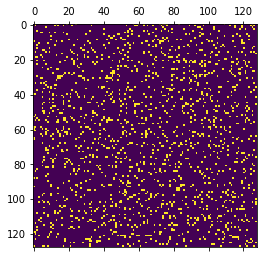

In [3]:
# Pattern generation, random with p(xi=1)=a

P = 9  # random patterns to learn
ap = 0.1  # pattern activity
X = binom.rvs(n=1, p=ap, size=(P, N))
plt.matshow(X[0].reshape(128,128)), np.mean(X)
np.shape(X)

activity: 0.1044921875


((10, 16384), 0.1044921875, 0.1044921875)

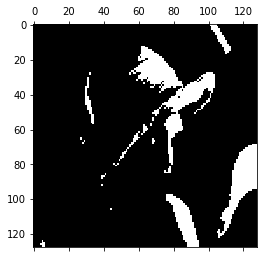

In [4]:
cmap = colors.ListedColormap(['black', 'white'])

img = Image.open('./lenna.png')
img = img.resize((128,128), Image.ANTIALIAS)
imggs = img.convert('L')
th_value = 185
imgbw = np.asarray(imggs)
imgbw = (imgbw > th_value)*1
imgbw = imgbw
plt.matshow(imgbw, cmap=cmap)
print('activity:', np.mean(imgbw))
lenna = imgbw.reshape(1, 128*128)
X = np.concatenate((X, lenna))
np.shape(X), np.mean(lenna), np.mean(X[-1])

In [5]:
threshold = (1-2*ap)/(2*np.sqrt(ap*(1-ap)))
nX = np.array([(x - np.mean(x))/np.sqrt(np.mean(x)*(1-np.mean(x))) for x in X])
np.shape(X), np.mean(nX), np.std(nX), threshold

((10, 16384), -7.632783294297952e-18, 1.0, 1.3333333333333333)

In [6]:
# Weights initialization
W = np.array([np.zeros(len(ci)) for ci in C])

#for each pattern x in X
for x in nX:
    # for each node i
    for i in range(N):
        W[i] = W[i] + x[C[i]]*x[i]

In [7]:
def normalize_vector(vector):
    av = np.mean(vector)
    return (vector - av)/np.sqrt(av*(1-av))

def act_threshold(neighbors, th):
    threshold = th
    if np.mean(neighbors) > 0.5:
        threshold = -th
    return threshold

(0.0, 1.0)

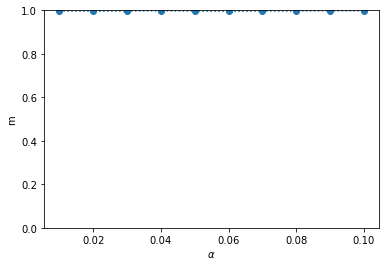

In [8]:
# Measure the quality of retrieval 
M = []  # M is 1, perfect retrieval, M is 0 no retrieval

#for each pattern x in X
for x in X:
    xt = np.copy(x)  # pattern x in time 0
    
    m = [np.sum(normalize_vector(x)*normalize_vector(xt))/N]  # initianl overlap in time 0, x is equal to xt, so m=1
    
    # update network for 100 steps
    for ti in range(100):
        # update each neuron xt[nxi]
        xt = np.array([(np.mean(normalize_vector(xt[C[nxi]])*W[nxi]) 
                        - act_threshold(xt[C[nxi]], threshold) >= 0)  # TH(local_field, threshod)
                       if np.var(xt[C[nxi]])  # if variance is not zero
                       else xt[nxi]  # state does not change otherwise
                       for nxi in range(N)])
        xt = xt.astype('int')
        m += [np.sum(normalize_vector(x)*normalize_vector(xt))/N]  # calculate overlap
        if m[-1] == m[-2]:
            break
    M += [m[-1]]
    
plt.plot(np.array(range(1,len(X)+1))/k, M, ':o')
plt.xlabel(r"$\alpha$")
plt.ylabel("m")
plt.ylim((0,1))

0.1044921875

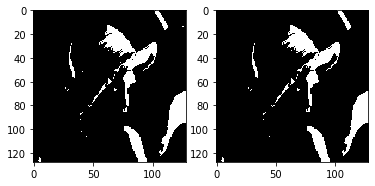

In [9]:
plt.subplot(1,2,1)
plt.imshow(xt.reshape((128,128)), cmap=cmap)
plt.subplot(1,2,2)
plt.imshow(imgbw, cmap=cmap)

np.mean(X[-1])

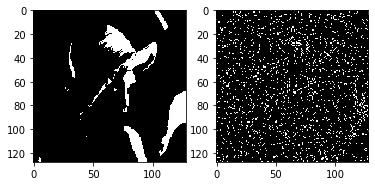

In [12]:
noise_level = 0.9

noisy_lenna = lenna.copy()

for i in range(np.shape(noisy_lenna)[1]):
    if np.random.random() < noise_level:
        noisy_lenna[0, i] = bernoulli.rvs(ap)

plt.subplot(1,2,1)
plt.imshow(X[-1].reshape((128,128)), cmap=cmap)
plt.subplot(1,2,2)
plt.imshow(noisy_lenna.reshape((128,128)), cmap=cmap)

0.00360107421875
0.02740478515625
0.0360107421875
0.10491943359375


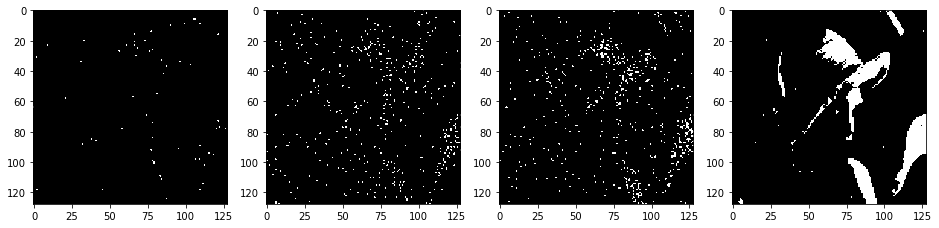

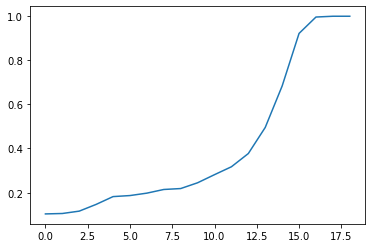

0.99804441364684

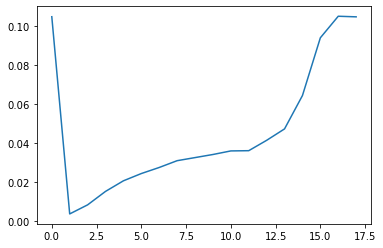

In [13]:
x = X[-1]  # Learned Lenna is in X, last pattern

xt = np.copy(noisy_lenna.flatten())  # init network in noisy lenna
        
m = [np.sum(normalize_vector(x)*normalize_vector(xt))/N]  # initial overlap

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,32))
ploti = 0

a_net = []

for ti in range(100):
    # network update for t=100
    a_net += [np.mean(xt)]
    # update each neuron xt[nxi]
    xt = np.array([(np.mean(normalize_vector(xt[C[nxi]])*W[nxi]) 
                    - act_threshold(xt[C[nxi]], threshold) >= 0)  # TH(local_field, threshod)
                   if np.var(xt[C[nxi]])  # if variance is not zero
                   else xt[nxi]  # state does not change otherwise
                   for nxi in range(N)])
    xt = xt.astype('int')
    m += [np.sum(normalize_vector(x)*normalize_vector(xt))/N]  # test overlap x and xt (net state)
    if not (ti % 5):
        print(np.mean(xt))
        ax[ploti].imshow(xt.reshape((128,128)), cmap=cmap)
        ploti += 1
    if m[-1] == m[-2]:
        break
plt.show()
plt.plot(m)
plt.show()
plt.plot(a_net)
m[-1]